Imports

In [91]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import matplotlib.pyplot as plt
import requests
import time
import os
import copy
import seaborn as sns

from pathlib import Path
from matplotlib import pyplot as plt
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from sklearn.metrics import confusion_matrix
from PIL import Image
# from torch.optim import lr_scheduler
# from torchvision import datasets, models, transforms


Display the matplotlib images inline, and set to interactive mode

In [92]:
%matplotlib inline

plt.ion()

First, load the dataset and print some of the images just to test the loader correctly.

In [93]:
img_32x32_size_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((32, 32)),  # ensure that images are 32x32
    torchvision.transforms.ToTensor(),
    # torchvision.transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]), # normalize to [-1,1]
])

gtsrb_path = "/content"

train_percent = 0.8 # 80% training set -> 20% validation set

train_set = torchvision.datasets.GTSRB(root=gtsrb_path, split='train', download=True, transform=img_32x32_size_transform)

train_size = int(train_percent*len(train_set))

val_size = int(len(train_set) - train_size)

train_set, val_set = random_split(train_set,[train_size, val_size])

test_set = torchvision.datasets.GTSRB(root=gtsrb_path, split='test', download=True, transform=img_32x32_size_transform)

test_set_size = int(len(test_set)*0.9)

test_vis_size= int(len(test_set) - test_set_size)

test_set, test_vis_set = random_split(test_set,[test_set_size,test_vis_size])

training_path = f"{gtsrb_path}/gtsrb/GTSRB/Training"

Setting the hyper parameters

In [94]:
bs = 64  # batch size
lr = 0.01  # learning rate
epochs = 20  # number of epochs
momentum = 0.9 # for optimizer
step_size = 7 # step size for
gamma = 0.1 # gamma for learning rate scheduler

Initializing the classes label names

In [95]:
class_names = [
    "Speed limit (20km/h)",         # 0
    "Speed limit (30km/h)",         # 1
    "Speed limit (50km/h)",         # 2
    "Speed limit (60km/h)",         # 3
    "Speed limit (70km/h)",         # 4
    "Speed limit (80km/h)",         # 5
    "End of speed limit (80km/h)",  # 6
    "Speed limit (100km/h)",        # 7
    "Speed limit (120km/h)",        # 8
    "No passing",                   # 9
    "No passing for vehicles over 3.5 metric tons",  # 10
    "Right-of-way at the next intersection",         # 11
    "Priority road",                # 12
    "Yield",                        # 13
    "Stop",                         # 14
    "No vehicles",                  # 15
    "Vehicles over 3.5 metric tons prohibited",      # 16
    "No entry",                     # 17
    "General caution",              # 18
    "Dangerous curve to the left",  # 19
    "Dangerous curve to the right", # 20
    "Double curve",                 # 21
    "Bumpy road",                   # 22
    "Slippery road",                # 23
    "Road narrows on the right",    # 24
    "Road work",                    # 25
    "Traffic signals",              # 26
    "Pedestrians",                  # 27
    "Children crossing",            # 28
    "Bicycles crossing",            # 29
    "Beware of ice/snow",           # 30
    "Wild animals crossing",        # 31
    "End of all speed and passing limits",  # 32
    "Turn right ahead",             # 33
    "Turn left ahead",              # 34
    "Ahead only",                   # 35
    "Go straight or right",         # 36
    "Go straight or left",          # 37
    "Keep right",                   # 38
    "Keep left",                    # 39
    "Roundabout mandatory",         # 40
    "End of no passing",            # 41
    "End of no passing by vehicles over 3.5 metric tons"  # 42
]

Creating the loader for the data

In [96]:
train_data_loader = DataLoader(train_set,batch_size=bs, shuffle=True) # schuffle only in train set
val_data_loader = DataLoader(val_set,batch_size=bs, shuffle=False)
test_data_loader = DataLoader(test_set,batch_size=bs, shuffle=False)
test_vis_data_loader = DataLoader(test_vis_set, batch_size=bs, shuffle=False)

data_loaders = {
    "train": train_data_loader,
    "val" : val_data_loader,
    "test": test_data_loader,
    "vis": test_vis_data_loader
}

data_set_sizes = {
    "train": len(train_data_loader),
    "val": len(val_data_loader),
    "test": len(test_data_loader),
    "vis": len(test_vis_data_loader)
}

Optionally print some images out of the dataset (since batch size is 64, we get 64 images out of the dataset)

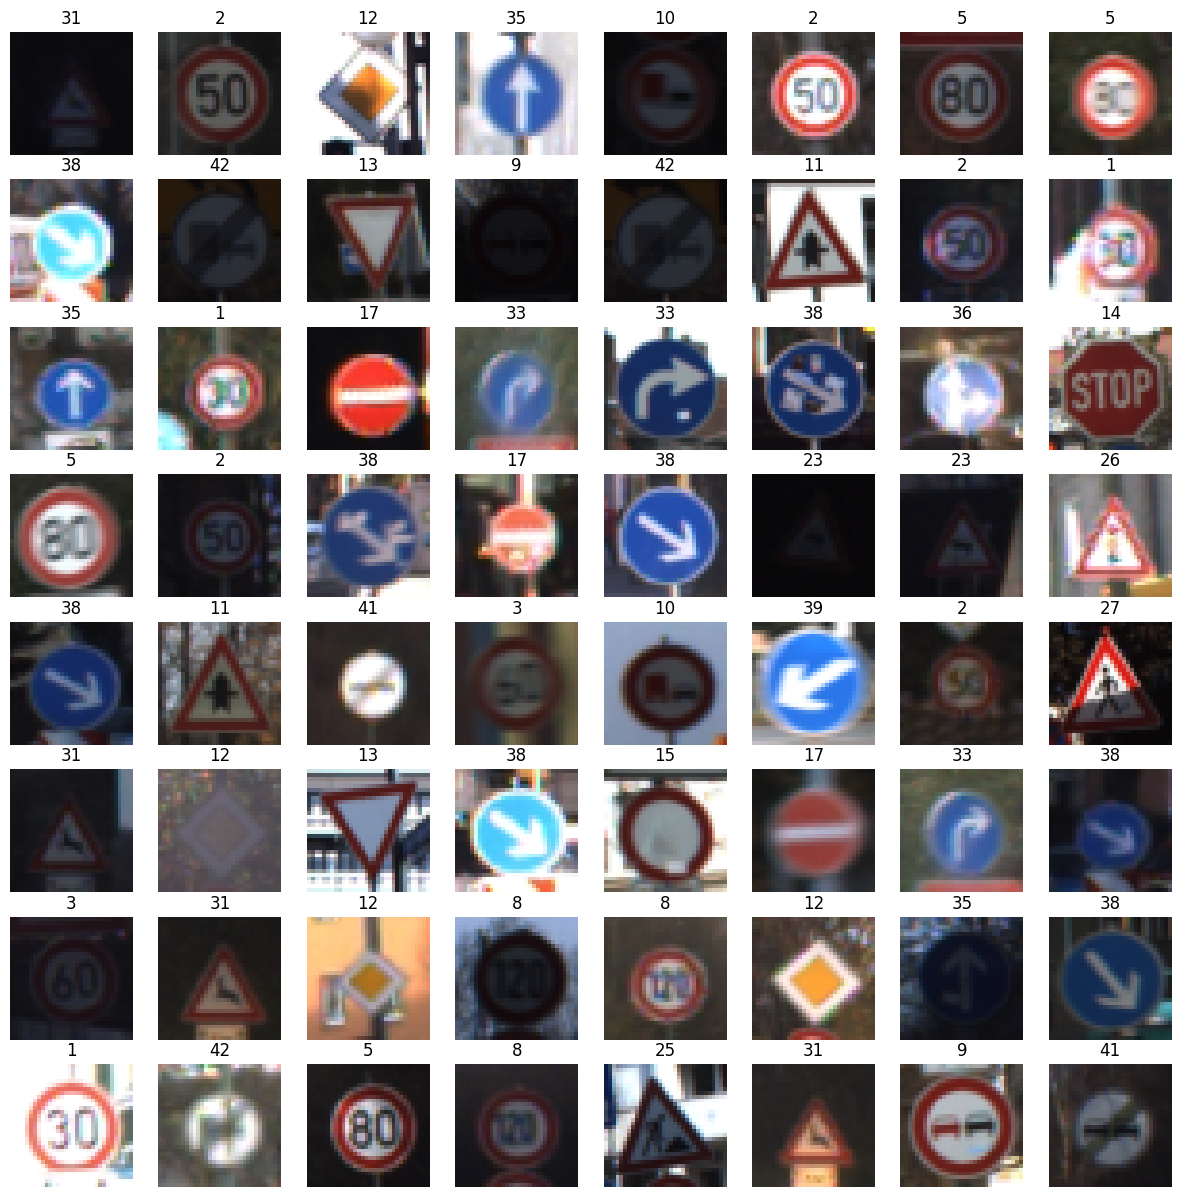

In [97]:
def imshow(images, labels):
  plt.figure(figsize=(15,15))
  for i in range(len(images)):
    plt.subplot(8,8,i+1)
    plt.imshow(images[i].permute(1,2,0)) # (3, 32, 32) -> (32, 32, 3)
    plt.title(labels[i].item())
    plt.axis("off")
  plt.show()

images, labels = next(iter(test_vis_data_loader)) # get a pack (64) of images

imshow(images, labels)

Setting up the model

In [98]:
model = torchvision.models.mobilenet_v2(weights=torchvision.models.MobileNet_V2_Weights.DEFAULT)

in_feature_number = model.classifier[1].in_features

model.classifier = nn.Sequential(   # setting the top layers of the classifier to custom
    nn.Linear(in_feature_number, 512),
    # nn.BatchNorm1d(512), # eps=1e-05, momentum=0.1,
    nn.ReLU(),
    nn.Linear(512, 43)
)

# print(model)
print('\nModel is built')


Model is built


Using the GPU if available

In [99]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device)

cuda:0


Visualizing the loss and accuracy for validation and training

In [100]:
def visualize_loss_and_acc(train_acc, val_acc, train_loss, val_loss):
    plt.figure(figsize=(10,10))

    plt.subplot(1,2,1)
    plt.plot(train_acc, label="Training accuracy")
    plt.plot(val_acc, label="Validation accuracy")
    plt.title("Training and Validation accuracy")

    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(train_loss, label="Training loss")
    plt.plot(val_loss, label="Validation loss")
    plt.title("Training and Validation loss")

    plt.legend()

    plt.show()

Functions to show metrics for gradients and weights in the model.

In [101]:
## Gradients

def plot_gradient_norms(model):
    grad_norms = []
    for name, param in model.named_parameters():
        if param.grad is not None:
            grad_norms.append(param.grad.norm().item())
    if grad_norms != []:
        plt.plot(grad_norms)
        plt.xlabel("Layer")
        plt.ylabel("Gradient Norm")
        plt.title("Gradient Norms Across Layers")
        plt.show()

def plot_gradient_histogram(model):
    all_grads = []
    for param in model.parameters():
        if param.grad is not None:
            all_grads.append(param.grad.view(-1))
    if all_grads != []:
      all_grads = torch.cat(all_grads).cpu().numpy()

      plt.hist(all_grads, bins=100, range=(-1, 1))  # Adjust range if necessary
      plt.xlabel("Gradient Value")
      plt.ylabel("Frequency")
      plt.title("Gradient Histogram")
      plt.show()

def plot_gradient_heatmap(model):
    for name, param in model.named_parameters():
        if param.grad is not None and param.grad.ndimension() == 2:
            grad = param.grad.cpu().numpy()
            plt.figure(figsize=(10, 1))
            sns.heatmap(grad, cmap="coolwarm", cbar=True)
            plt.title(f"Gradient heatmap for {name}")
            plt.show()

## Weights

def plot_weight_norms(model):
    weight_norms = []
    for name, param in model.named_parameters():
        if 'weight' in name:
            weight_norms.append(param.data.norm().item())
    plt.plot(weight_norms, marker="o")
    plt.xlabel("Layer")
    plt.ylabel("Weight Norm")
    plt.title("Weight Norms Across Layers")
    plt.show()

def plot_weight_histogram(model):
    for name, param in model.named_parameters():
        if 'weight' in name:
            weights = param.data.cpu().numpy()
            plt.figure(figsize=(6, 4))
            plt.hist(weights.ravel(), bins=100)
            plt.xlabel("Weight Value")
            plt.ylabel("Frequency")
            plt.title(f"Weight Histogram for {name}")
            plt.show()

def plot_weight_heatmap(model):
    for name, param in model.named_parameters():
        if 'weight' in name and param.data.ndimension() == 2:  # Fully connected layers
            weights = param.data.cpu().numpy()
            plt.figure(figsize=(10, 5))
            sns.heatmap(weights, cmap="coolwarm", cbar=True)
            plt.title(f"Weight Heatmap for {name}")
            plt.show()

def visualize_conv_filters(model):
    for name, param in model.named_parameters():
        if 'conv' in name and 'weight' in name:
            weights = param.data.cpu()
            num_filters = weights.shape[0]  # Number of filters
            fig, axes = plt.subplots(1, min(num_filters, 8), figsize=(12, 4))
            for i in range(min(num_filters, 8)):  # Show up to 8 filters
                filter = weights[i].squeeze()
                axes[i].imshow(filter, cmap="gray")
                axes[i].set_title(f"Filter {i}")
                axes[i].axis("off")
            plt.suptitle(f"Filters for {name}")
            plt.show()

Function to call visualizations

In [102]:
def visualize_after_training_metrics(model, train_acc, val_acc, train_loss, val_loss):
  visualize_loss_and_acc(train_acc, val_acc, train_loss, val_loss)
  plot_weight_norms(model)
  plot_weight_histogram(model)
  plot_weight_heatmap(model)

def visualize_gradients(model):
  plot_gradient_norms(model)
  plot_gradient_histogram(model)
  plot_gradient_heatmap(model)


Setting up the training method

In [103]:
# Generic function to train a model
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    model = model.to(device)

    # Copy weights
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    train_acc = []
    val_acc = []
    train_loss = []
    val_loss = []

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        print('-' * 20)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in data_loaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history only if in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                curr_loss = loss.item() * inputs.size(0)
                curr_corrects = torch.sum(preds == labels.data)

                running_loss += curr_loss
                running_corrects += curr_corrects

            epoch_loss = running_loss / data_set_sizes[phase]
            epoch_acc = running_corrects.double() / data_set_sizes[phase]

            visualize_gradients(model)

            # if phase == 'train':
            #     scheduler.step()

            if phase == 'train':
                train_acc += [float(epoch_acc)]
                train_loss += [float(epoch_loss)]
            else:
                val_acc += [float(epoch_acc)]
                val_loss += [float(epoch_loss)]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)

    return model, train_acc, val_acc, train_loss, val_loss

Setting up the visualizing method

In [104]:
def evaluate_model(model):
    was_training = model.training
    model.eval()

    model = model.to(device)

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(data_loaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

        model.train(mode=was_training)

    conf_matrix = confusion_matrix(all_labels, all_preds)
    conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
    return conf_matrix_normalized

Method to show some predictions on unseen images

In [105]:
def show_predictions(model, num_of_images=6):
    was_training = model.training
    model.eval()
    model = model.to(device)
    images_so_far = 0
    fig = plt.figure(figsize=(12,12))

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(data_loaders['vis']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            inp_size = inputs.size()[1]

            for j in range(inp_size):
                images_so_far += 1
                ax = plt.subplot(inp_size, num_of_images//inp_size, images_so_far)
                ax.axis('off')
                ax.set_title(f"pred: {class_names[preds[j]]}\ntrue: {class_names[labels[j]]}")

                resized_image = torchvision.transforms.ToTensor()(torchvision.transforms.Resize((1024, 1024))(torchvision.transforms.ToPILImage()(inputs.cpu().data[j])))

                ax.imshow(resized_image.permute(1, 2, 0))

                if images_so_far == num_of_images:
                    model.train(mode=was_training)
                    return

        model.train(mode=was_training)

Preparing the model for feature extraction (original model's weights are freezed, classfier layer is trainable), setting the loss function, optimizer and learning rate scheduler

In [106]:
# Freeze all layers (i.e., disable training)
for param in model.parameters():
    param.requires_grad = False

# Unfreeze final layer (named fc)
for param in model.classifier.parameters():
    param.requires_grad = True

# Put the model on the GPU
model = model.to(device)

# Loss function
loss_function = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.Adam(model.parameters(), lr=lr)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

Train the model

Epoch 1/20
--------------------


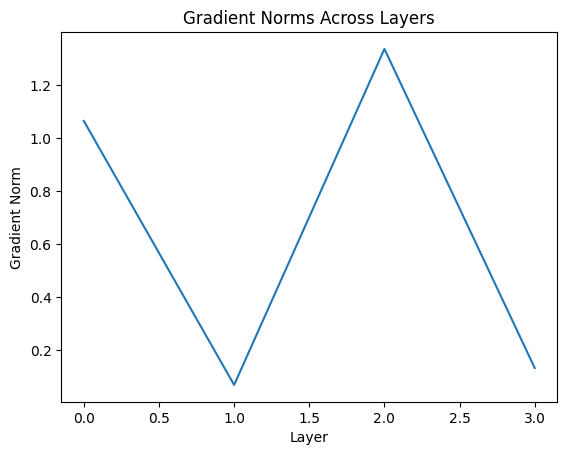

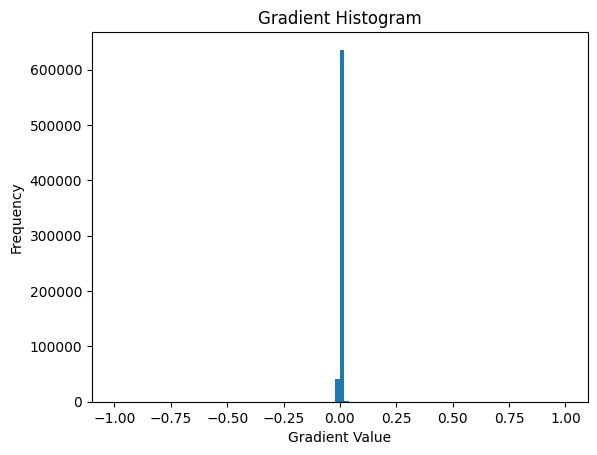

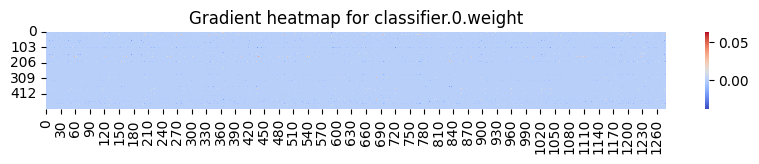

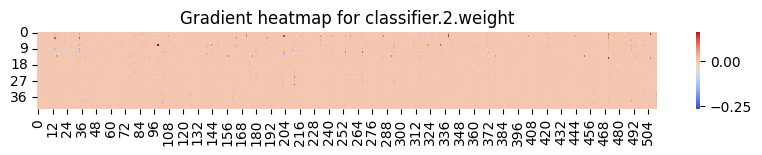

train Loss: 178.3048 Acc: 16.7568
val Loss: 154.0856 Acc: 22.3571
Epoch 2/20
--------------------


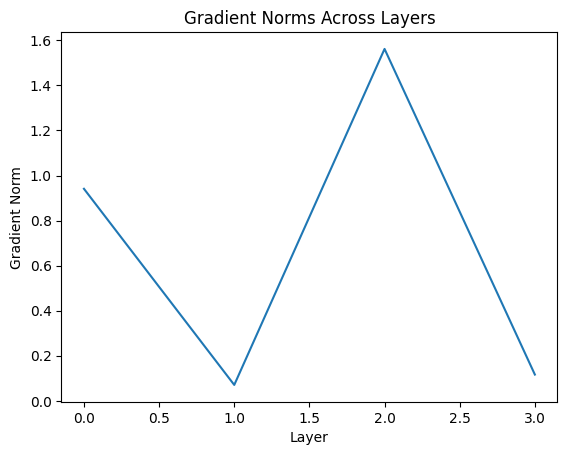

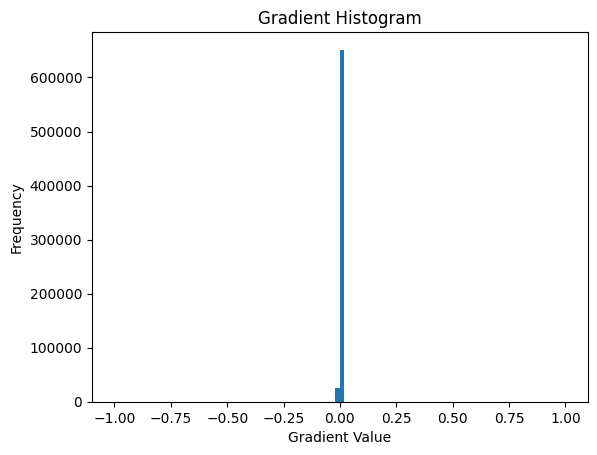

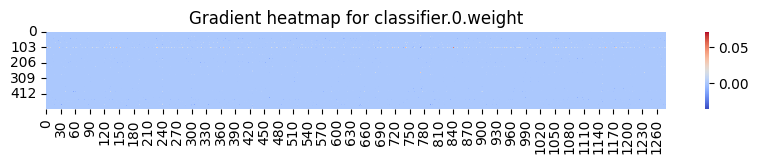

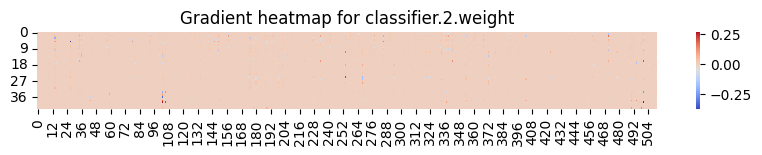

train Loss: 159.6995 Acc: 21.4474
val Loss: 146.5315 Acc: 24.2619
Epoch 3/20
--------------------


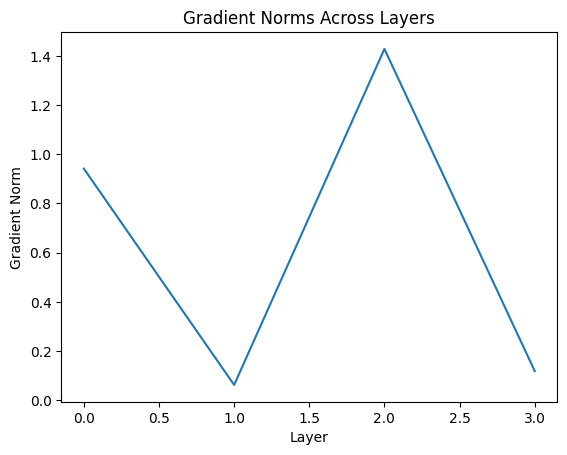

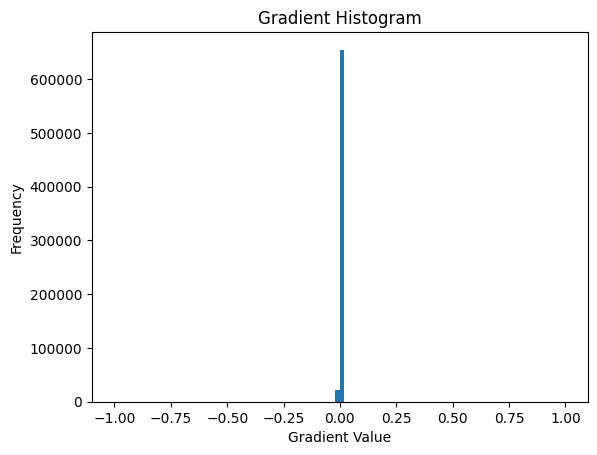

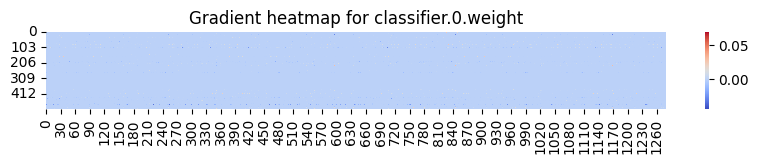

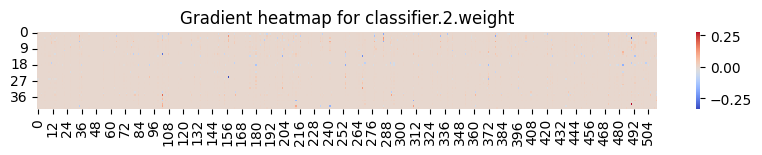

train Loss: 152.7426 Acc: 22.9009
val Loss: 141.7769 Acc: 25.9048
Epoch 4/20
--------------------


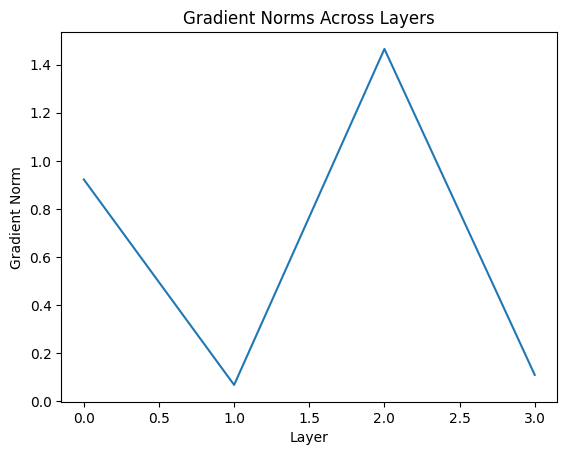

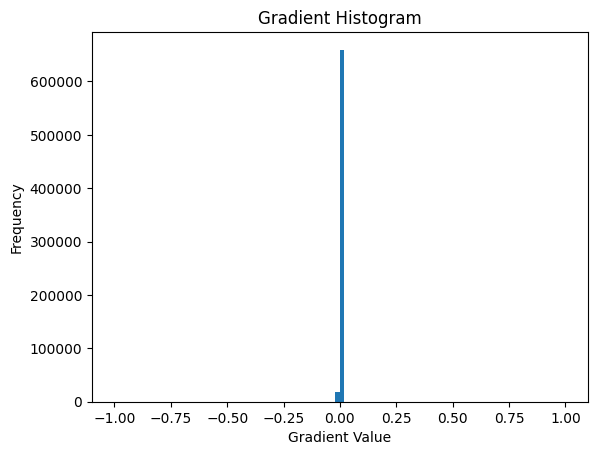

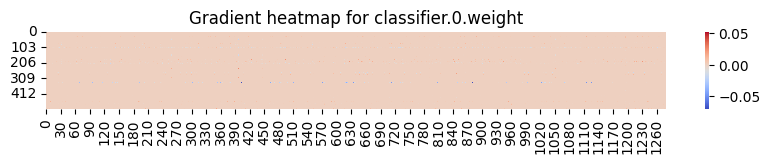

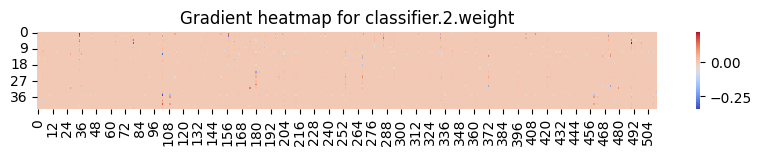

train Loss: 147.4399 Acc: 24.4865
val Loss: 139.2902 Acc: 26.7738
Epoch 5/20
--------------------


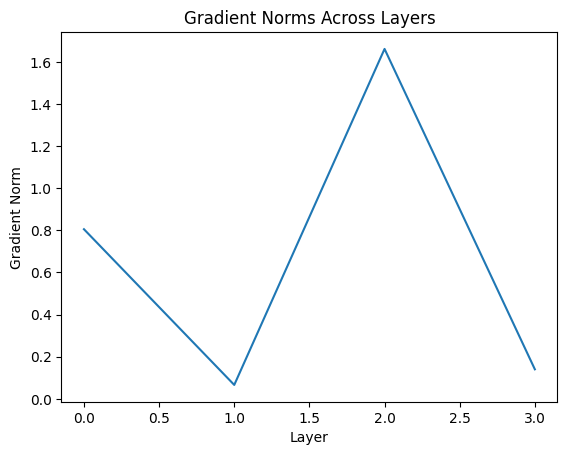

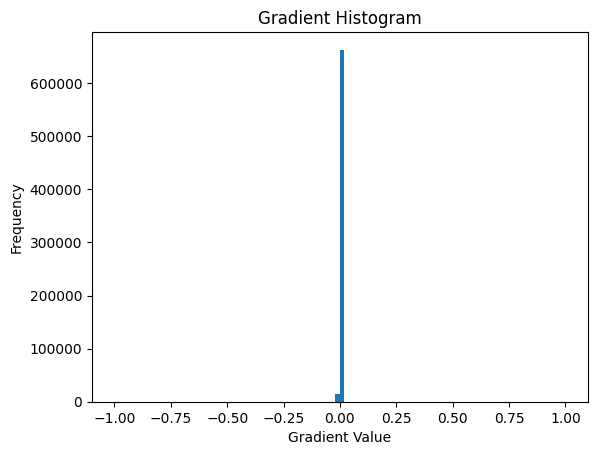

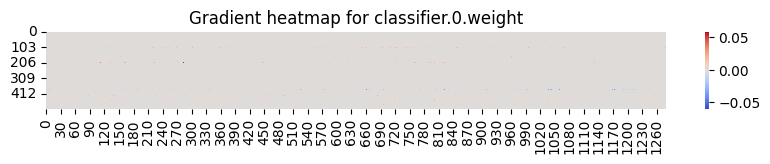

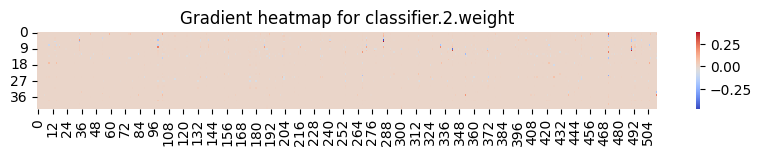

train Loss: 145.2266 Acc: 25.4625
val Loss: 137.6221 Acc: 26.8095
Epoch 6/20
--------------------


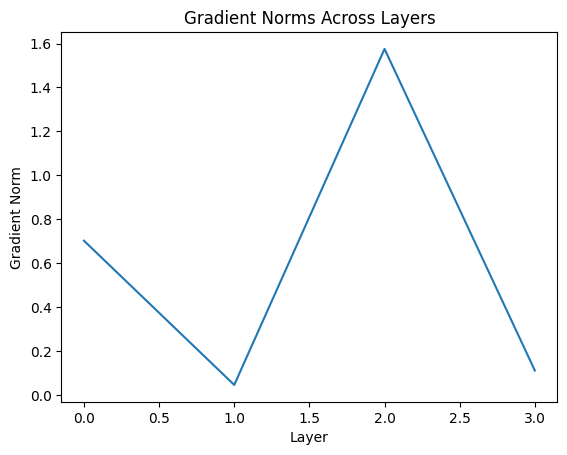

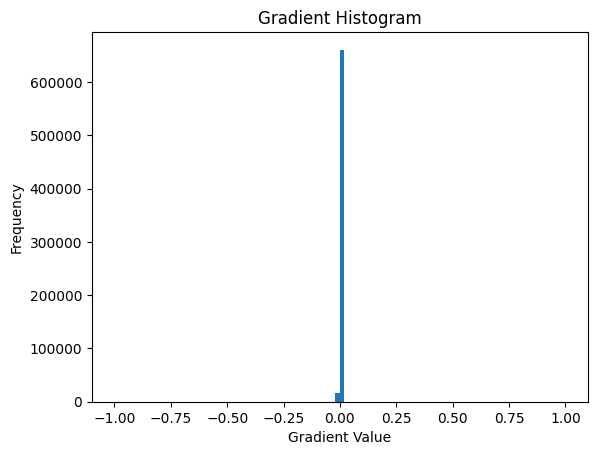

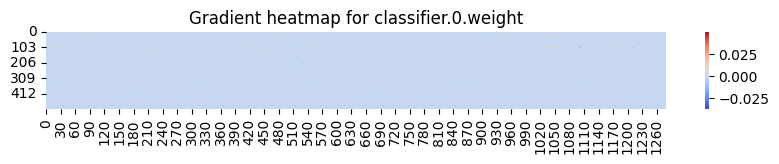

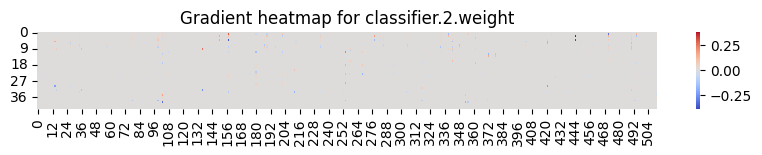

train Loss: 141.2812 Acc: 26.4745
val Loss: 137.5193 Acc: 27.9524
Epoch 7/20
--------------------


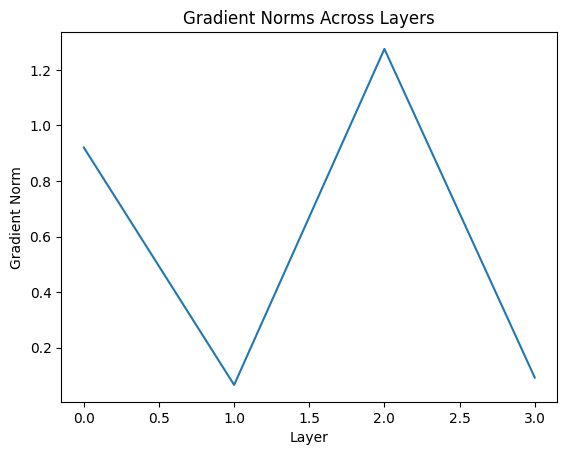

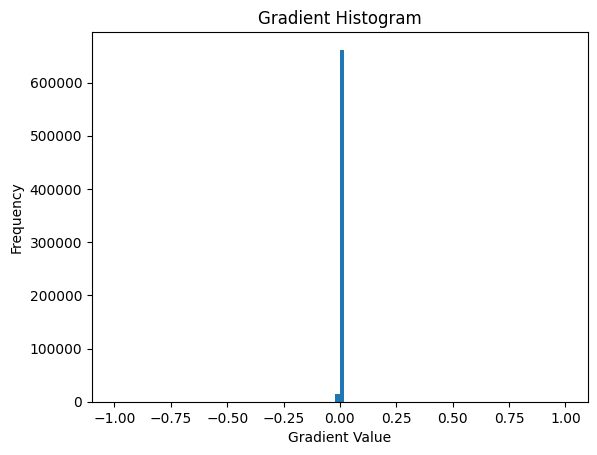

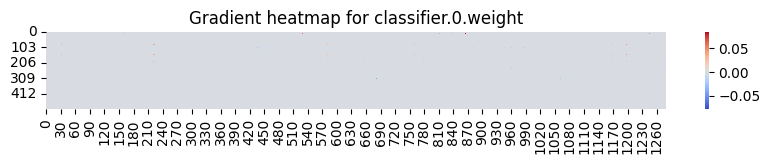

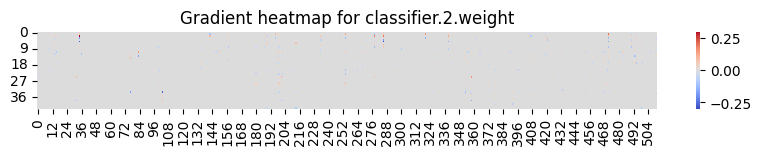

train Loss: 140.8662 Acc: 26.8919
val Loss: 136.6496 Acc: 28.0357
Epoch 8/20
--------------------


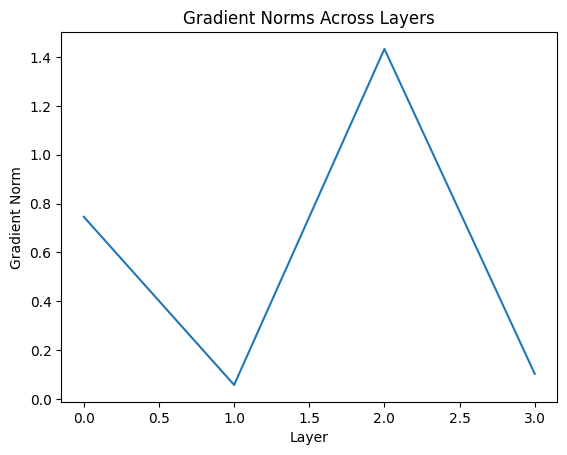

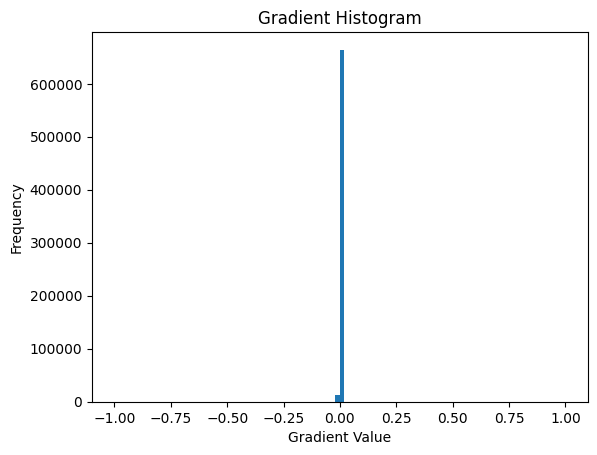

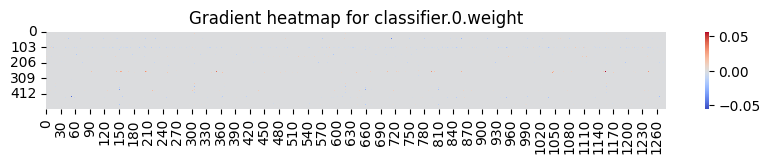

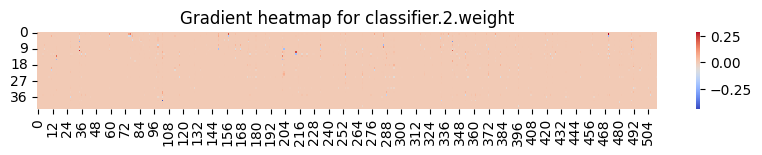

train Loss: 138.1693 Acc: 27.4384
val Loss: 135.7399 Acc: 28.1548
Epoch 9/20
--------------------


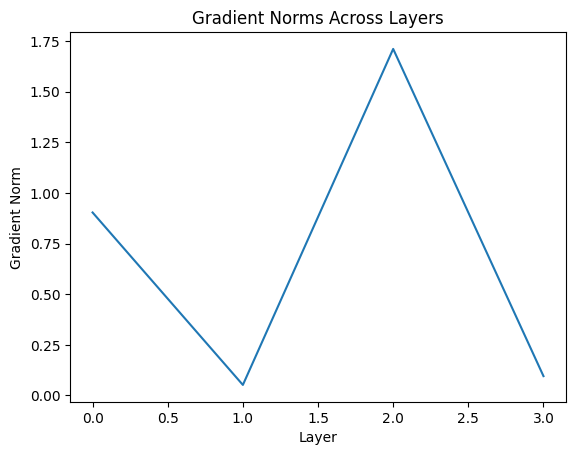

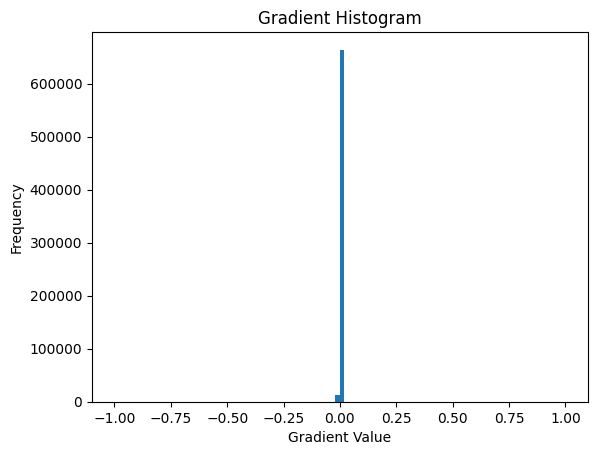

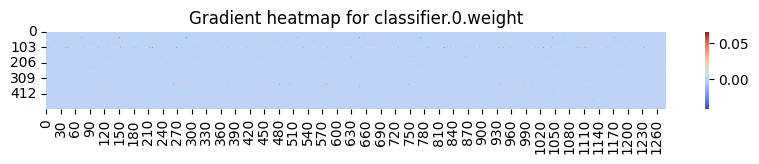

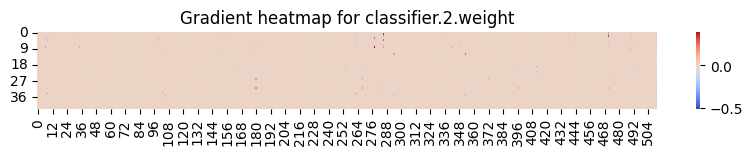

train Loss: 136.9654 Acc: 27.9700
val Loss: 134.4901 Acc: 29.1667
Epoch 10/20
--------------------


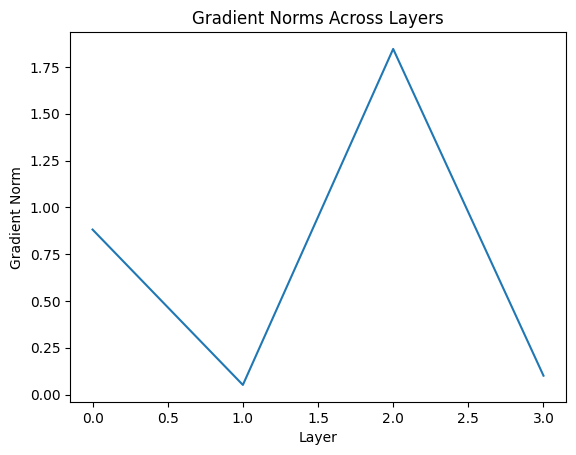

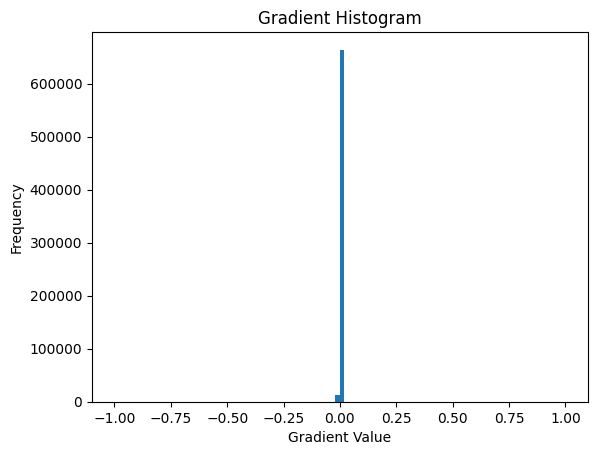

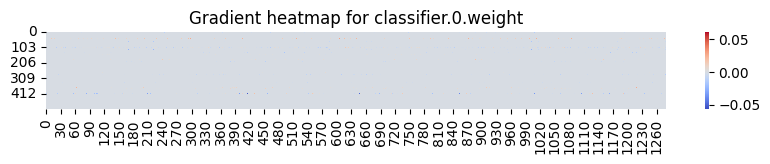

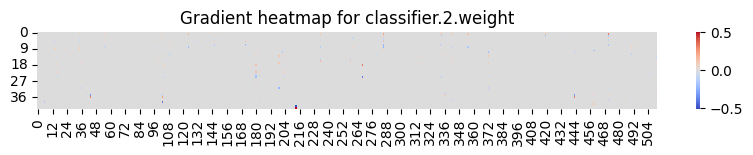

train Loss: 136.3485 Acc: 28.3514
val Loss: 134.9962 Acc: 29.0357
Epoch 11/20
--------------------


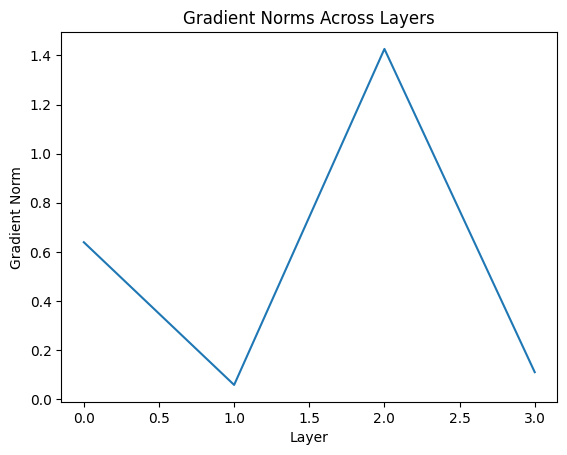

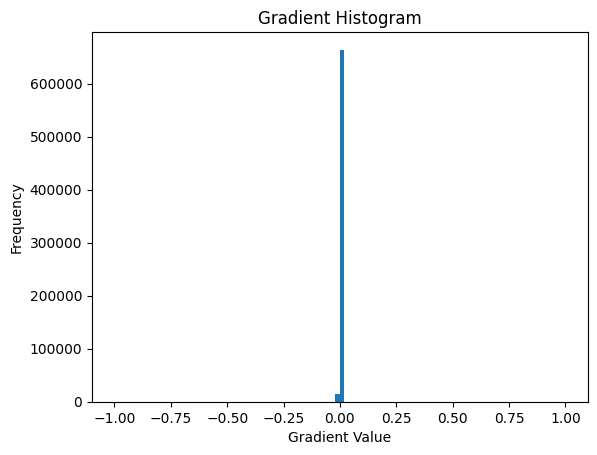

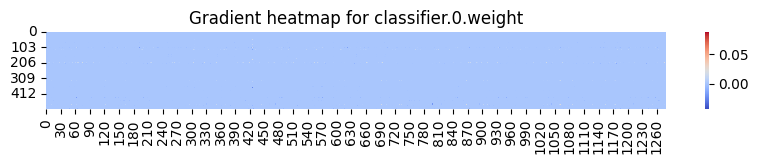

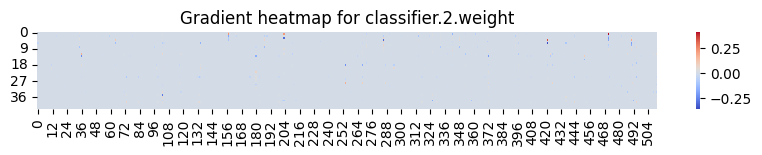

train Loss: 133.4847 Acc: 29.1742
val Loss: 132.9409 Acc: 29.3452
Epoch 12/20
--------------------


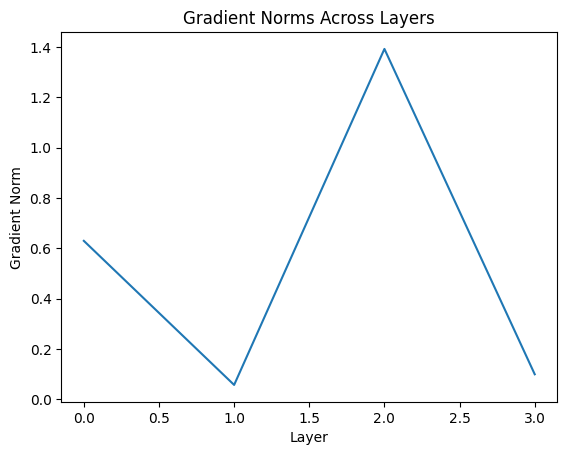

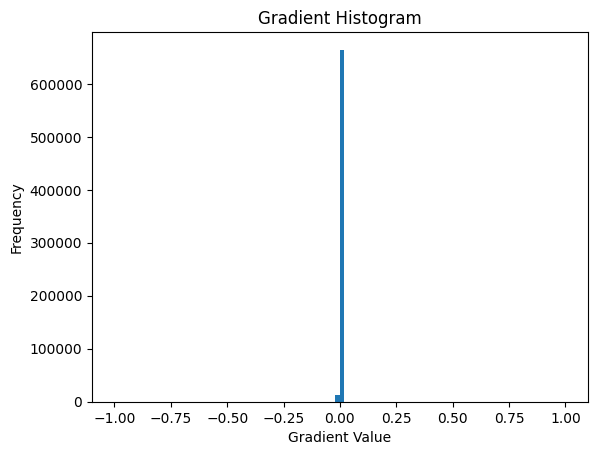

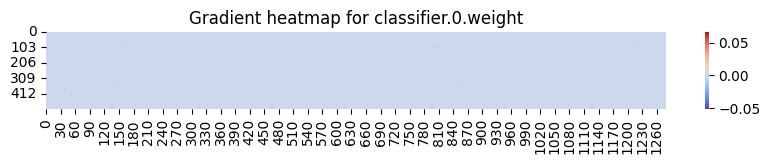

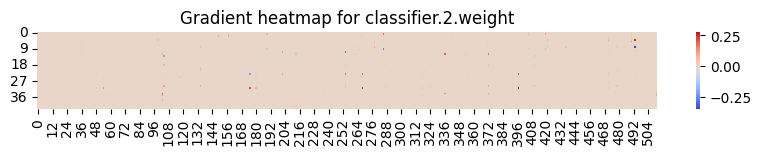

train Loss: 133.6232 Acc: 29.0601
val Loss: 132.3224 Acc: 29.8810
Epoch 13/20
--------------------


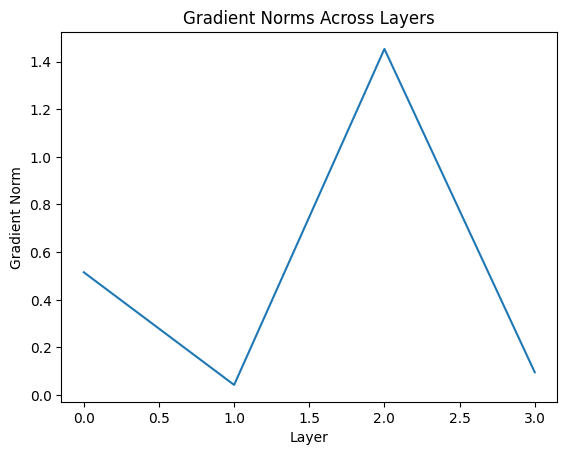

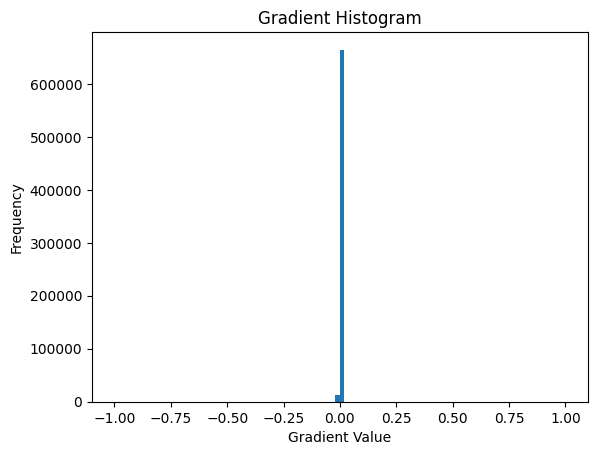

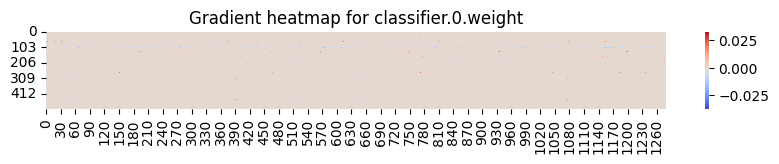

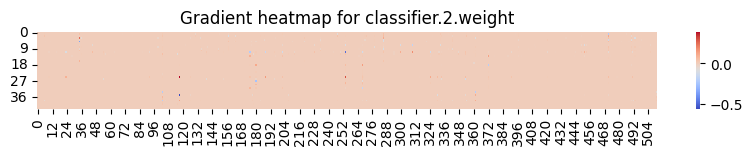

train Loss: 131.7355 Acc: 29.6486
val Loss: 131.9996 Acc: 30.5000
Epoch 14/20
--------------------


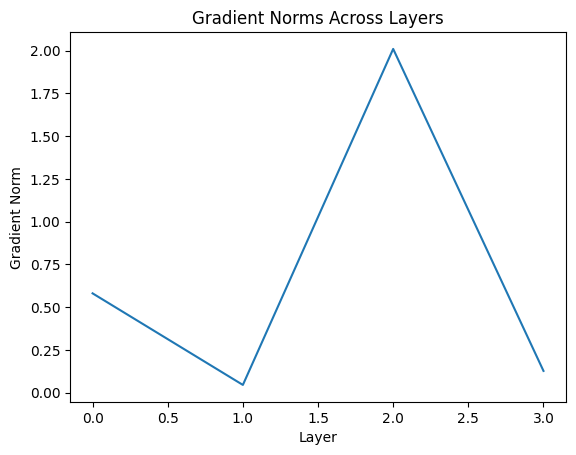

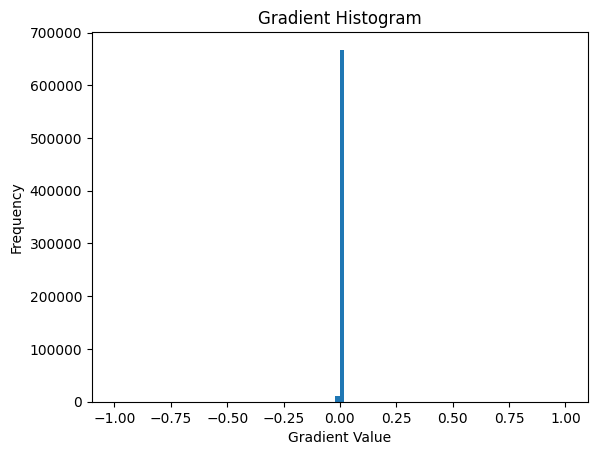

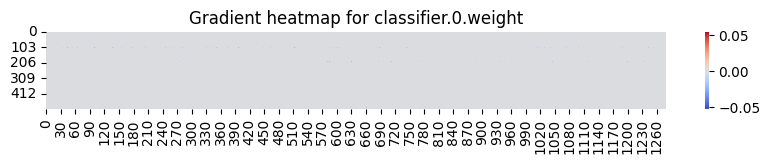

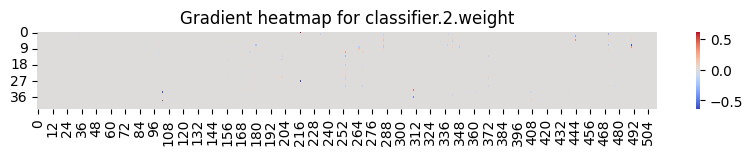

train Loss: 131.5607 Acc: 29.8889
val Loss: 128.0490 Acc: 30.9762
Epoch 15/20
--------------------


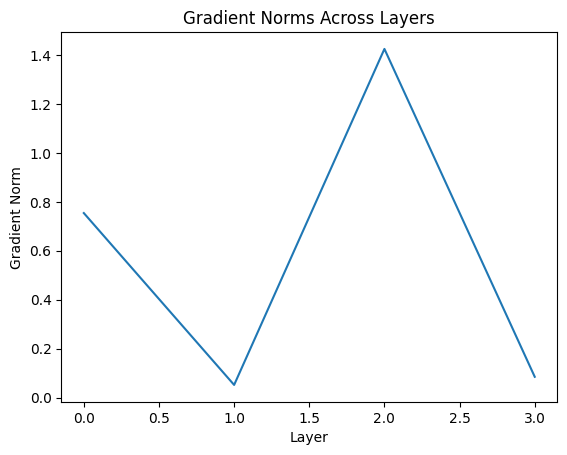

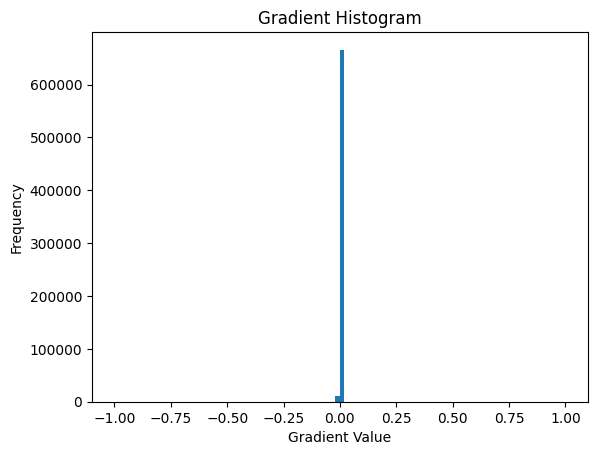

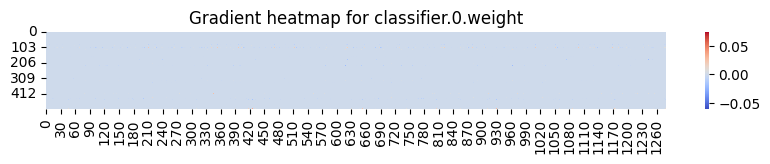

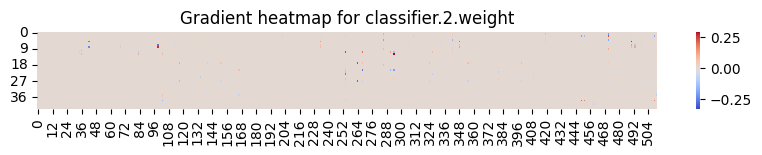

train Loss: 131.7793 Acc: 30.1081
val Loss: 133.1853 Acc: 30.7738
Epoch 16/20
--------------------


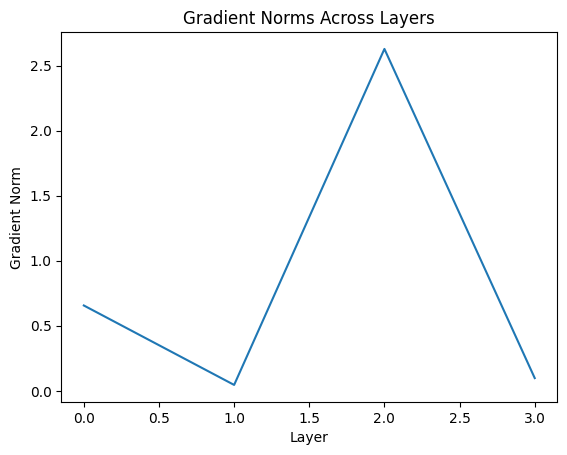

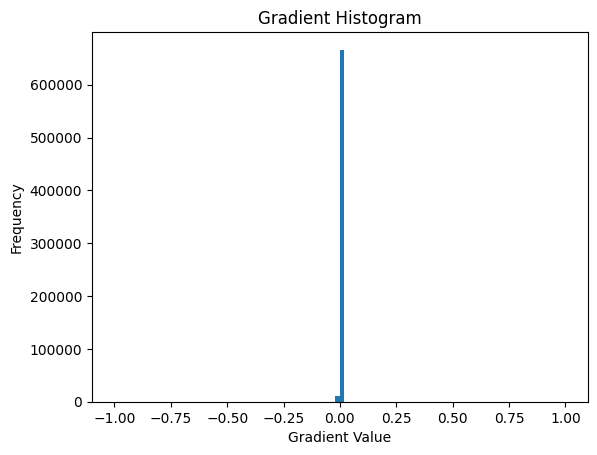

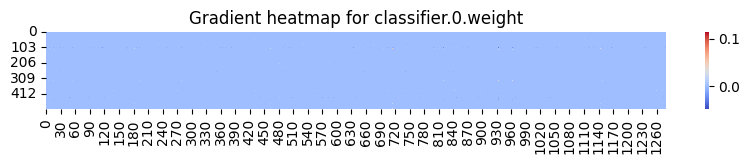

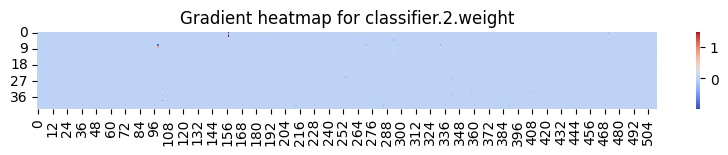

train Loss: 131.9334 Acc: 30.0270
val Loss: 134.7975 Acc: 30.0714
Epoch 17/20
--------------------


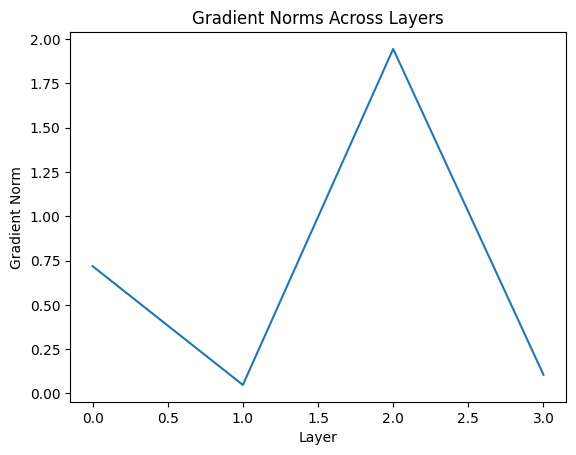

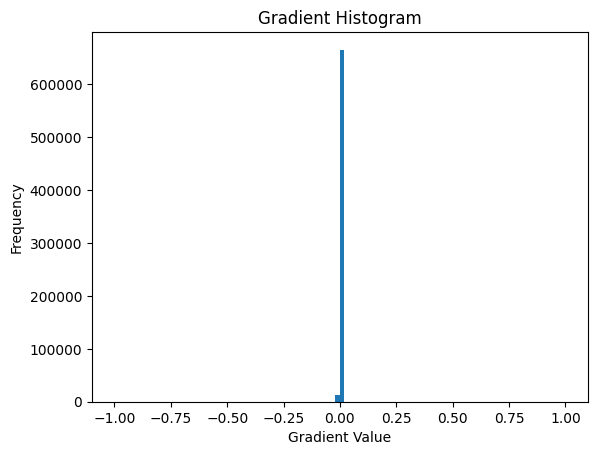

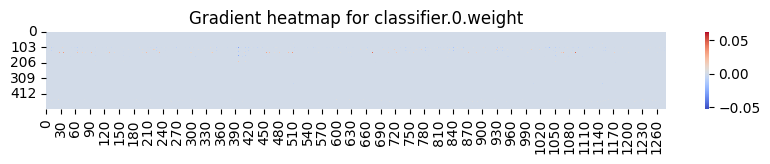

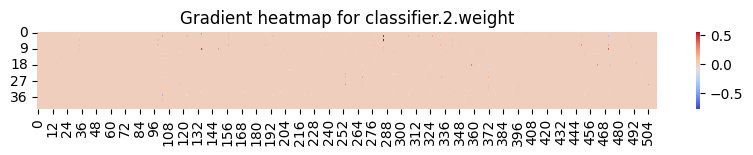

train Loss: 128.9302 Acc: 30.6517
val Loss: 127.7811 Acc: 31.1786
Epoch 18/20
--------------------


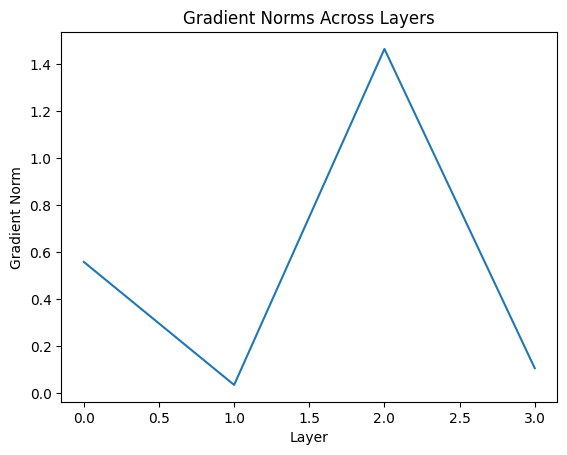

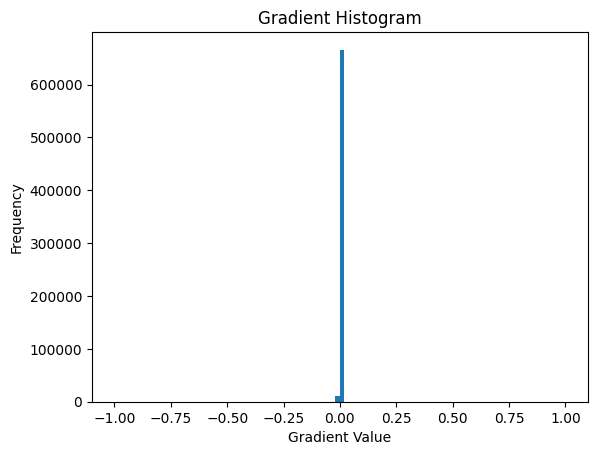

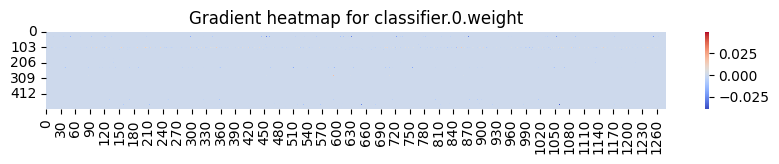

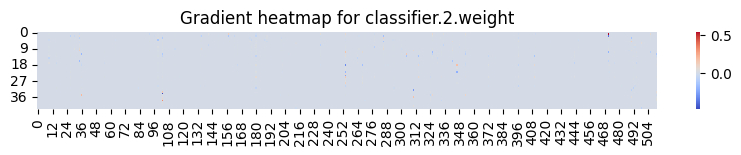

train Loss: 127.4372 Acc: 30.9850
val Loss: 129.0884 Acc: 31.1786
Epoch 19/20
--------------------


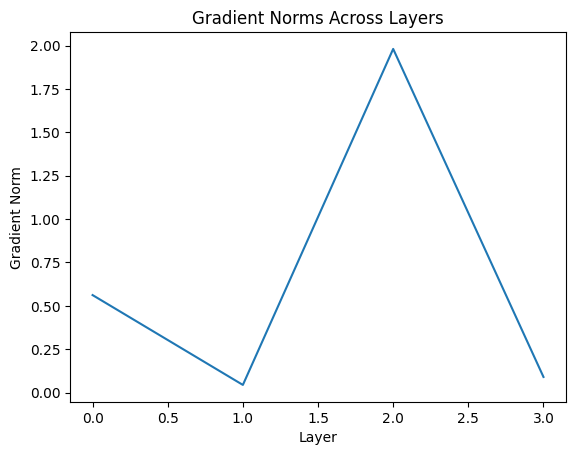

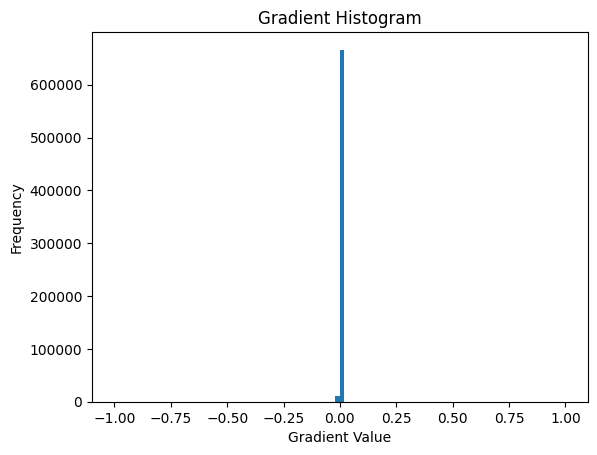

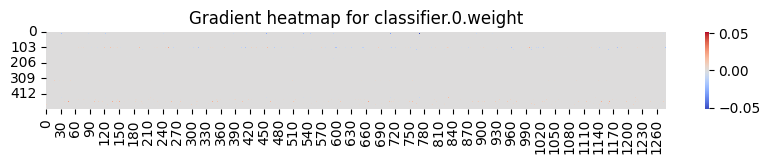

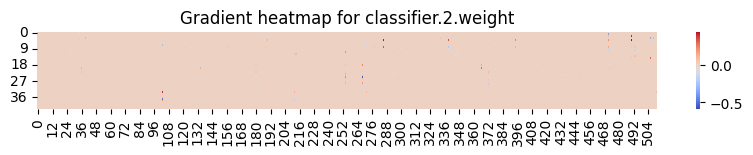

train Loss: 128.1794 Acc: 31.2583
val Loss: 128.2922 Acc: 31.2262
Epoch 20/20
--------------------


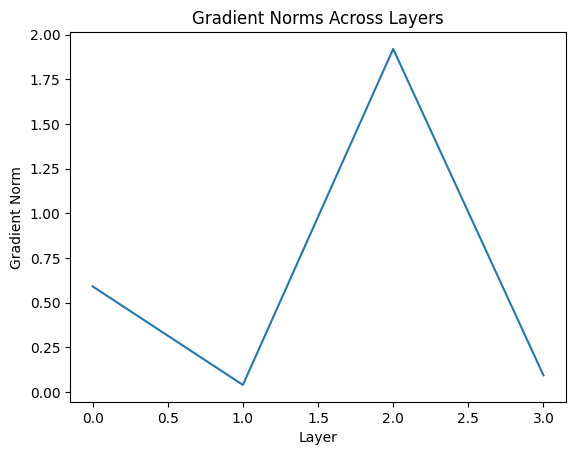

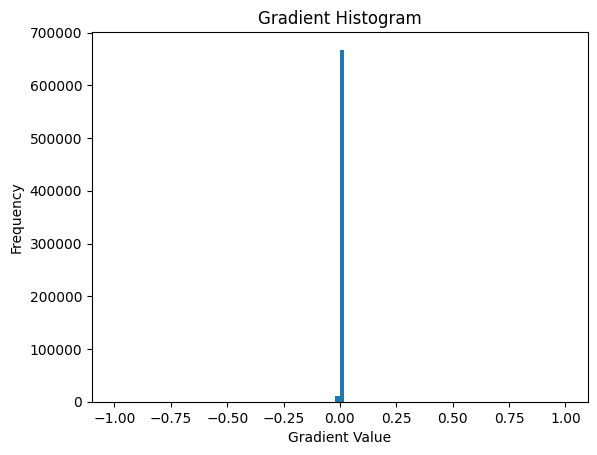

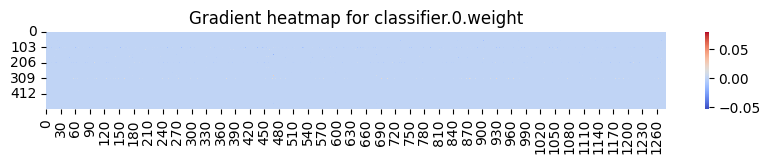

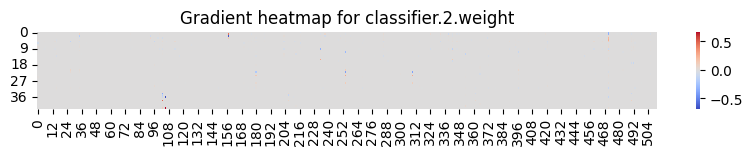

train Loss: 128.1161 Acc: 31.2402
val Loss: 130.4620 Acc: 31.4524
Training complete in 6m 35s
Best val Acc: 31.452381


In [107]:
model, train_acc, val_acc, train_loss, val_loss = train_model(model, loss_function, optimizer, exp_lr_scheduler, num_epochs=epochs)

In [108]:
print(train_loss)

[178.30483213774076, 159.69951125594588, 152.7426205196896, 147.43987741556253, 145.22658000407634, 141.28119407401786, 140.8662066531253, 138.16925660554352, 136.96540484270892, 136.34851232305303, 133.4846631528379, 133.62323586862007, 131.73551480404964, 131.56067430650864, 131.7793270947339, 131.93340379411393, 128.93015882703992, 127.43724385396138, 128.17941714908267, 128.11607271486574]


Call the visualizations

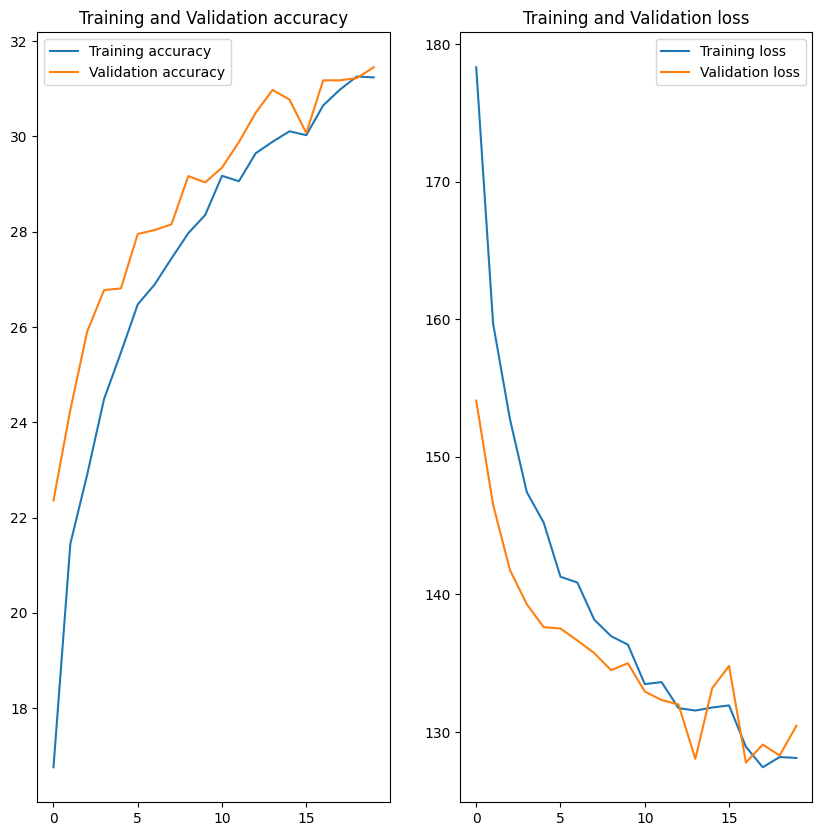

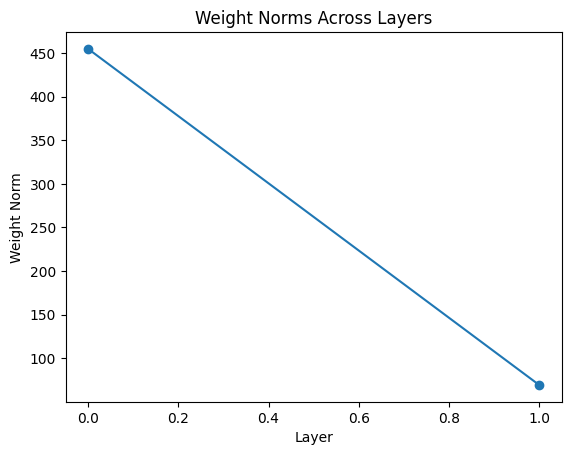

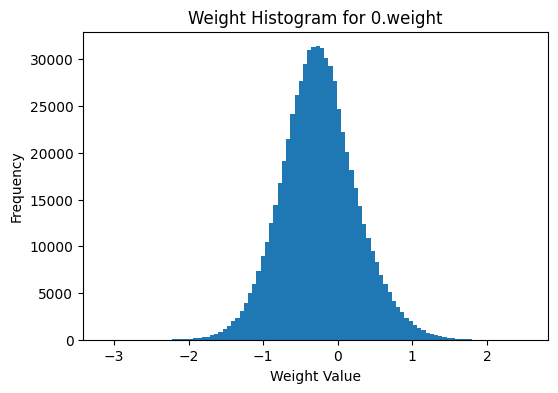

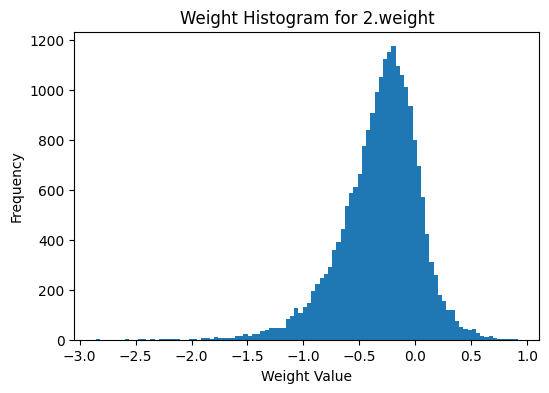

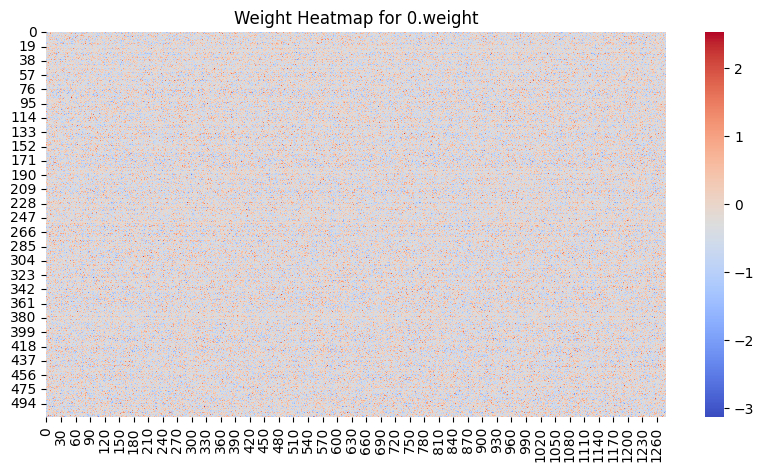

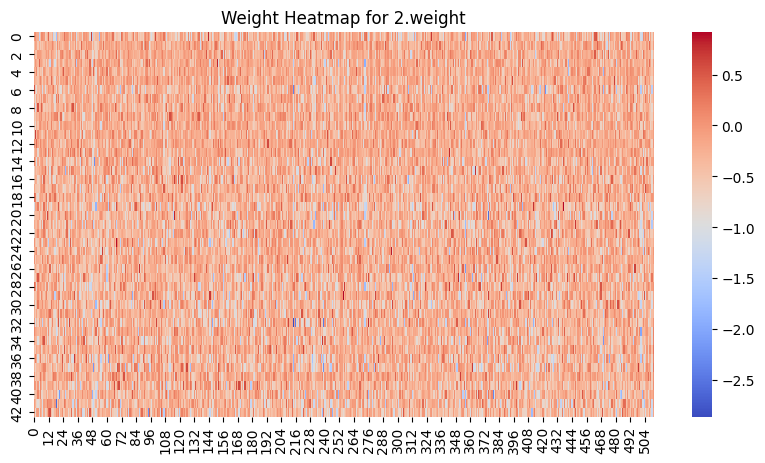

In [109]:
visualize_after_training_metrics(model.classifier, train_acc, val_acc, train_loss, val_loss)

Evaluate the model form the test data loader

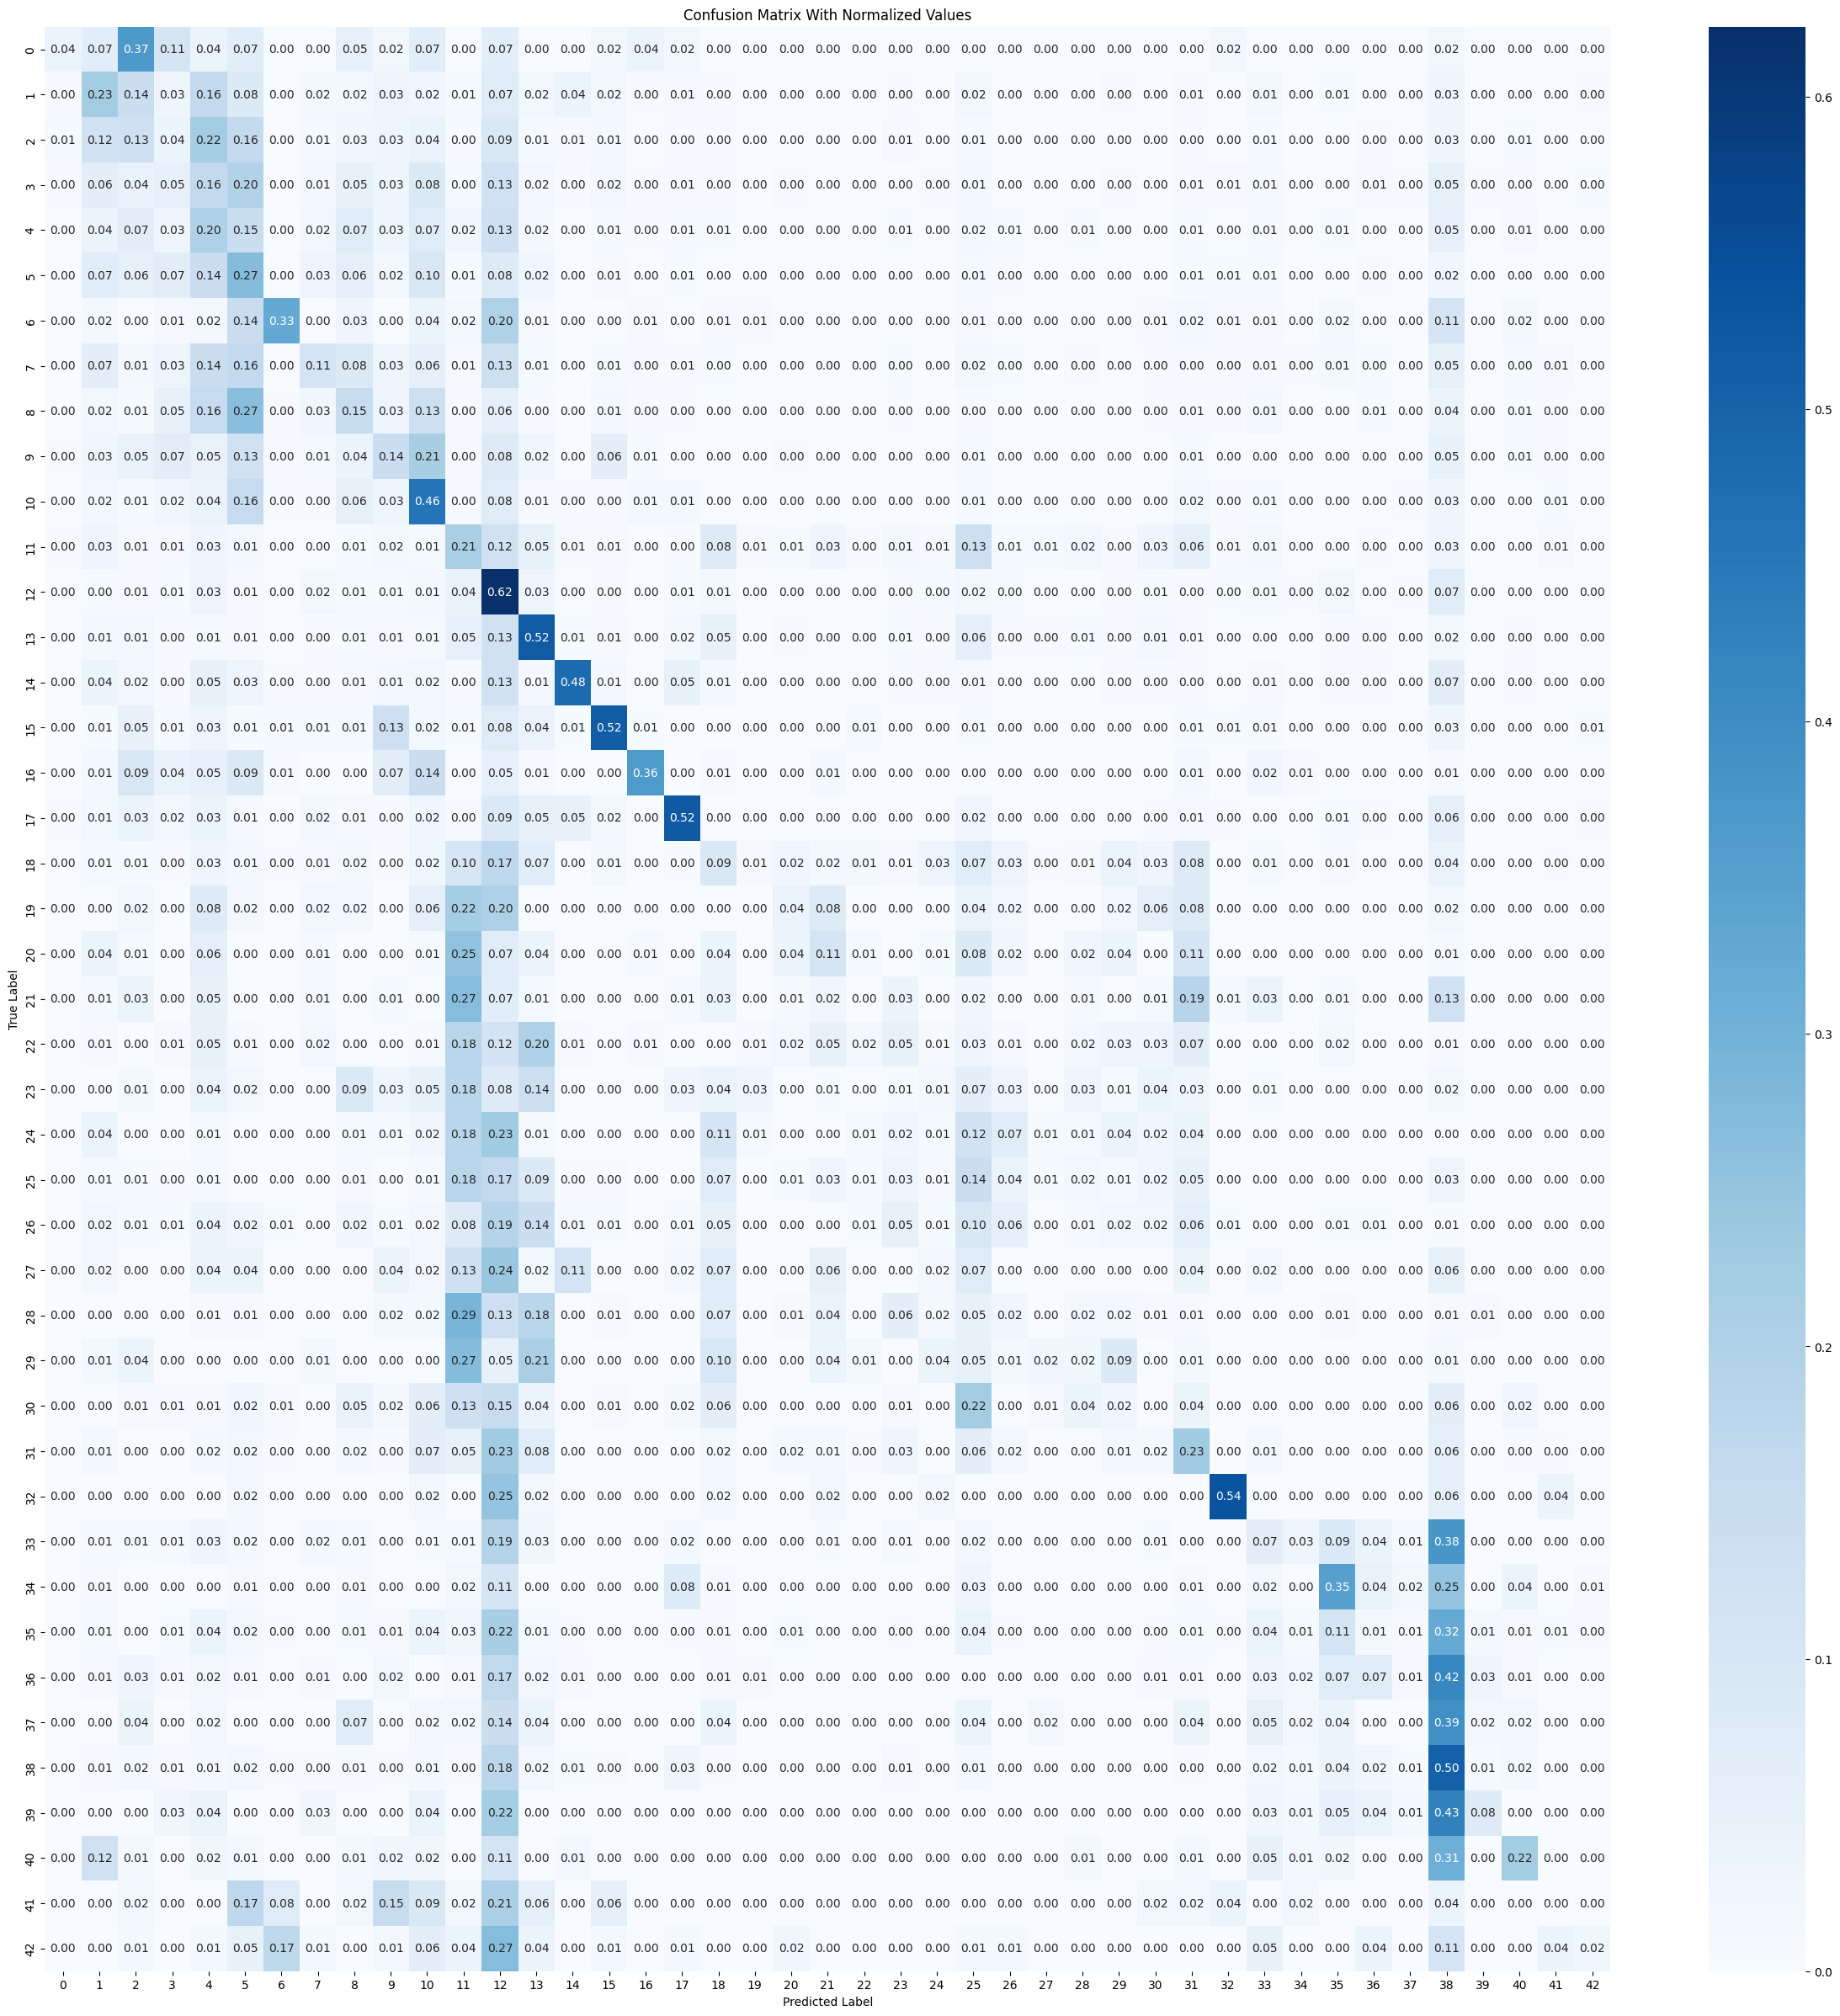

In [111]:
conf_matrix = evaluate_model(model)

plt.figure(figsize=(30,30))
sns.heatmap(conf_matrix, annot=True, fmt=".2f", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix With Normalized Values")
plt.show()

Show some predictions with the model

In [ ]:
show_predictions(model) # 6 images are shown by default

Fine tuning model

In [ ]:
for param in model.parameters(): # unfreeze every trainable parameter
    param.requires_grad = True

Train the model again

In [ ]:
model,train_acc2, val_acc2, train_loss2, val_loss2 = train_model(model, loss_function, optimizer, exp_lr_scheduler, num_epochs=epochs)

Visualize results

In [ ]:
visualize_after_training_metrics(model.classifier, train_acc2, val_acc2, train_loss2, val_loss2)

Show some predictions with the fine tuned model again

In [ ]:
conf_matrix = evaluate_model(model)

plt.figure(figsize=(30,30))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()